In [144]:
%matplotlib inline

import copy
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
from scipy.stats import binom, norm

import time
import torch as pt 
from tqdm import tqdm

device = pt.device('cuda:0')

## SDE

Let 
$$p_\mathrm{data} = \sum_{m=1}^M \alpha_m \mathcal{N}(\mu_m, \Sigma_m).$$ 
We consider the Ornstein-Uhlenbeck process 
$$
\mathrm d X_s = -AX_s \mathrm d s + B \mathrm d W_s, \qquad X_0 \sim p_\mathrm{data},
$$
with $A = 1, B = \sqrt{2}$.

In [492]:
M = 2
mu = [-2, 2]
sigma = [0.5, 0.5]
alpha = [1 / M] * M

def density(x, t):
    return np.sum([alpha[m] * norm.pdf(x, loc=np.exp(-A * t) * mu[m], 
        scale=np.sqrt(B**2 / (2 * A) * (1 - np.exp(-2 * A * t)) + np.exp(-2 * A * t) * sigma[m]**2)) 
                          for m in range(M)], 0)

def score(x, t):
    return (np.sum([- (x - np.exp(-A * t) * mu[m]) / 
                    (B**2 / (2 * A) * (1 - np.exp(-2 * A * t)) + np.exp(-2 * A * t) * sigma[m]**2)
                    * alpha[m] * norm.pdf(x, loc=np.exp(-A * t) * mu[m], 
        scale=np.sqrt(B**2 / (2 * A) * (1 - np.exp(-2 * A * t)) + np.exp(-2 * A * t) * sigma[m]**2)) 
                          for m in range(M)], 0) /
           density(x, t))

T = 2
delta_t = 0.01
sq_delta_t = np.sqrt(delta_t)
N = int(T / delta_t)
K = 10000
K_traj = 100
X_traj = np.zeros([N + 1, K_traj])
Y_traj = np.zeros([N + 1, K_traj])

A = 1
B = np.sqrt(2)

X_data = np.concatenate([np.random.normal(loc=mu[m], scale=sigma[m], size=int(K / M)) 
                         for m in range(M)], 0)
np.random.shuffle(X_data)
X = X_data
X_traj[0, :] = X[:K_traj]

for n in range(N):
    xi = np.random.normal(loc=0, scale=1, size=K)
    X = X - A * X * delta_t + B * xi * sq_delta_t
    X_traj[n + 1, :] = X[:K_traj] 
    
Y = np.random.normal(loc=0, scale=1, size=K)

for n in range(N):
    xi = np.random.normal(loc=0, scale=1, size=K)
    Y = Y + (A * Y + B**2 * score(Y, T - n * delta_t)) * delta_t + B * xi * sq_delta_t
    Y_traj[n + 1, :] = Y[:K_traj] 

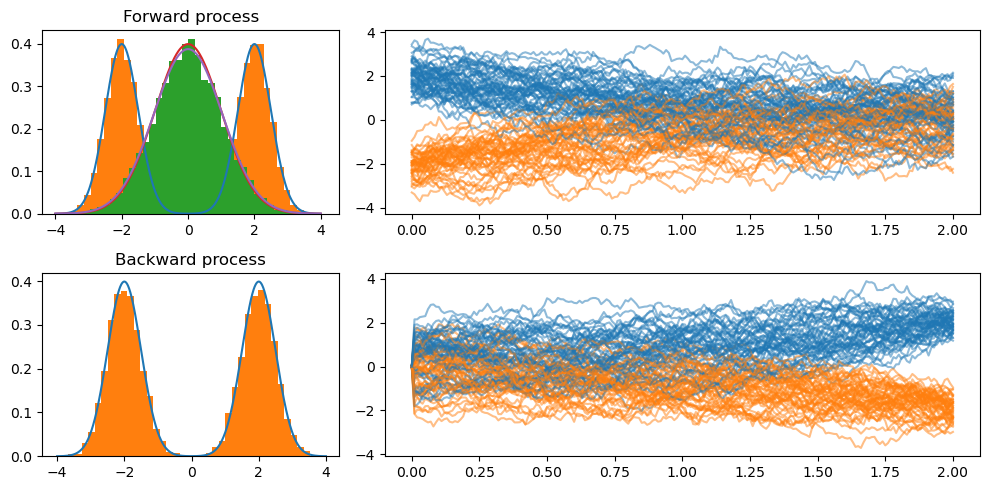

In [493]:
COLORS = ["tab:blue", "tab:orange"]

x_val = np.linspace(-4, 4, 1000)
t_val = np.linspace(0, T, N + 1)

fig, ax = plt.subplots(2, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 2]})

ax[0, 0].set_title("Forward process")
ax[0, 0].plot(x_val, np.sum([alpha[m] * norm.pdf(x_val, loc=mu[m], scale=sigma[m]) 
                          for m in range(M)], 0));
ax[0, 0].hist(X_data, bins=40, density=True);
ax[0, 0].hist(X, bins=40, density=True);
ax[0, 0].plot(x_val, norm.pdf(x_val, loc=0, scale=1))
ax[0, 0].plot(x_val, density(x_val, T))

for k in range(K_traj):
    ax[0, 1].plot(t_val, X_traj[:, k], color=COLORS[int(X_traj[0, k] < 0)], alpha=0.5)

ax[1, 0].set_title("Backward process");
ax[1, 0].plot(x_val, np.sum([alpha[m] * norm.pdf(x_val, loc=mu[m], scale=sigma[m]) 
                          for m in range(M)], 0));
ax[1, 0].hist(Y, bins=40, density=True);

for k in range(K_traj):
    ax[1, 1].plot(t_val, Y_traj[:, k], color=COLORS[int(Y_traj[-1, k] < 0)], alpha=0.5)

fig.tight_layout()

## Ehrenfest process

In [362]:
K = 100000
X = np.random.binomial(S, p, size=K)

In [386]:
scaled_X = (X - S * p) / np.sqrt(S * p * (1 - p)) * 0.5
scaled_X[:int(K / 2)] -= 2
scaled_X[int(K / 2):] += 2

In [387]:
1 / np.sqrt(S * p * (1 - p)) #* 0.5

0.2

(-4.0, 4.0)

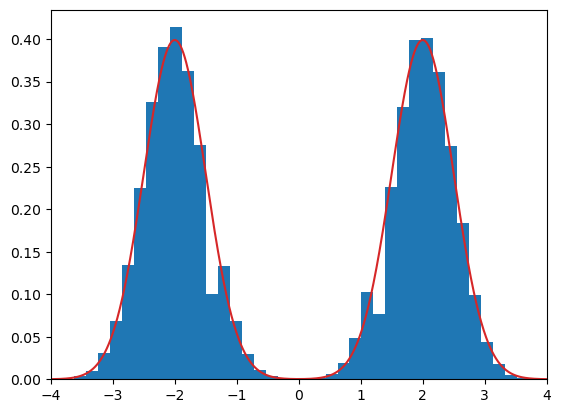

In [389]:
plt.hist(scaled_X, bins=np.max(np.unique(X)) - np.min(np.unique(X)), density=True)
# to do: bar
plt.plot(x_val, 0.5 * norm.pdf(x_val, loc=-2, scale=0.5) +
         0.5 * norm.pdf(x_val, loc=2, scale=0.5), color="tab:red")
plt.xlim(-4, 4)

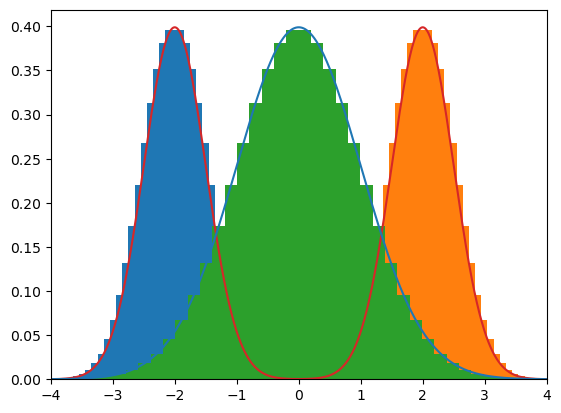

In [701]:
S = 101
p = 0.5

space = np.linspace(0, S, S + 1)

scaled_space = (space - S * p) / np.sqrt(S * p * (1 - p))

plt.bar(scaled_space * 0.5 - 2, np.sqrt(S * p * (1 - p)) * binom.pmf(space, S, p), 
        width=1 / np.sqrt(S * p * (1 - p_1)))
plt.bar(scaled_space * 0.5 + 2, np.sqrt(S * p * (1 - p)) * binom.pmf(space, S, p), 
        width=1 / np.sqrt(S * p * (1 - p_1)))
plt.plot(x_val, 0.5 * norm.pdf(x_val, loc=-2, scale=0.5) +
         0.5 * norm.pdf(x_val, loc=2, scale=0.5), color="tab:red")
plt.bar(scaled_space, np.sqrt(S * p * (1 - p)) * binom.pmf(space, S, p), 
        width=1 / np.sqrt(S * p * (1 - p_1)))
plt.plot(x_val, norm.pdf(x_val, loc=0, scale=1), color="tab:blue")
plt.xlim(-4, 4);

## reverse sampling

In [545]:
def score_pt(x, t):
    x = x.detach().cpu().numpy()
    return pt.tensor(np.sum([- (x - np.exp(-A * t) * mu[m]) / 
                    (B**2 / (2 * A) * (1 - np.exp(-2 * A * t)) + np.exp(-2 * A * t) * sigma[m]**2)
                    * alpha[m] * norm.pdf(x, loc=np.exp(-A * t) * mu[m], 
        scale=np.sqrt(B**2 / (2 * A) * (1 - np.exp(-2 * A * t)) + np.exp(-2 * A * t) * sigma[m]**2)) 
                          for m in range(M)], 0) /
           density(x, t)).to(device)

In [708]:
S = 101

In [709]:
S_extended = S
E_T = []

In [712]:
T = 2
samples = 100000
step = 2 / pt.sqrt(pt.tensor(S))

log_trajectories = 100
E_logs = []
time_logs = []

for sample in tqdm(range(samples)):
    
    if sample < log_trajectories:
        time_logs.append([])
        E_logs.append([])

    x_0 = pt.ones(1, 1) * int(S_extended / 2)
    t = pt.ones(1, 1).to(device) * T

    E_1 = pt.distributions.binomial.Binomial(total_count=x_0, 
                                             probs=0.5 * (1 + pt.exp(-t)))
    E_0 = pt.distributions.binomial.Binomial(total_count=S_extended - 1 - x_0, 
                                             probs=0.5 * (1 - pt.exp(-t)))

    E = (E_0.sample((1,)) + E_1.sample((1,))).squeeze(0).to(device)
    
    # scaled Ehrenfest
    E = 2 / pt.sqrt(pt.tensor(S - 1)) * (E - (S - 1) / 2)
    
    t = T

    if sample < log_trajectories:
        time_logs[-1] = [T]
        E_logs[-1] = [E.item()]

    while t > 0:
        
        E_t_t = pt.cat([E, pt.ones(1, 1).to(device) * t], 1)
        
        #birth_rate_forward = 0.5 * (S - 1 - (E - 1))
        #death_rate_forward = 0.5 * (E + 1)
        birth_rate_forward = pt.sqrt(pt.tensor(S - 1)) / 2 * 0.5 * (np.sqrt(S - 1) - E)
        death_rate_forward = pt.sqrt(pt.tensor(S - 1)) / 2 * 0.5 * (np.sqrt(S - 1) + E)

        birth_rate_backward = pt.maximum((1 + 2 / pt.sqrt(pt.tensor(S - 1)) * score_pt(E, t)) 
                                         * death_rate_forward, pt.tensor(0.000001))
        death_rate_backward = pt.maximum((1 - 2 / pt.sqrt(pt.tensor(S - 1)) * score_pt(E, t)) 
                                         * birth_rate_forward, pt.tensor(0.000001))
        
        birth = pt.distributions.Exponential(birth_rate_backward)
        death = pt.distributions.Exponential(death_rate_backward)

        t_b = birth.sample((1,)).squeeze()
        t_d = death.sample((1,)).squeeze()

        if t_b < t_d: 
            t -= t_b.item()
            E += step
        else:
            t -= t_d.item()
            E -= step
            
        E = pt.clamp(E, -pt.sqrt(pt.tensor(S).to(device)), pt.sqrt(pt.tensor(S).to(device)))

        if sample < log_trajectories:
            time_logs[-1].append(t)
            E_logs[-1].append(E.item())

    E_T.append(E.item())

#plt.plot(time_log, N_log);

 11%|███▋                              | 10925/100000 [20:52<2:51:43,  8.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 34%|██████████▊                     | 33858/100000 [1:04:38<2:05:12,  8.80it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 61%|███████████████████▍            | 60770/100000 [1:55:55<1:15:31,  8.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order t

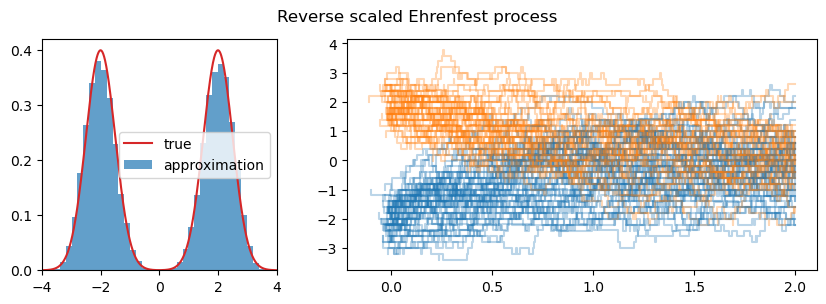

In [713]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [1, 2]})

fig.suptitle("Reverse scaled Ehrenfest process")

E_T_counts = np.bincount(np.round(((np.array(E_T) / 2 *
                          np.sqrt(S) + S / 2) )).astype("int"), minlength=S)
p_approx = E_T_counts / np.sum(E_T_counts)

ax[0].plot(x_val, 0.5 * norm.pdf(x_val, loc=-2, scale=0.5) +
         0.5 * norm.pdf(x_val, loc=2, scale=0.5), color="tab:red", label="true")
ax[0].bar(x=(np.linspace(0, S-1, S) - S / 2) * 2 / np.sqrt(S), width=2 / np.sqrt(S), height=p_approx / 2 * np.sqrt(S), alpha=0.7, label="approximation");
ax[0].legend();
ax[0].set_xlim(-4, 4)

for i in range(log_trajectories):
    ax[1].plot(np.repeat(time_logs[i], 2)[1:], np.repeat(E_logs[i], 2)[:-1], alpha=0.3,
             color=COLORS[int(E_logs[i][-1] > 0)])

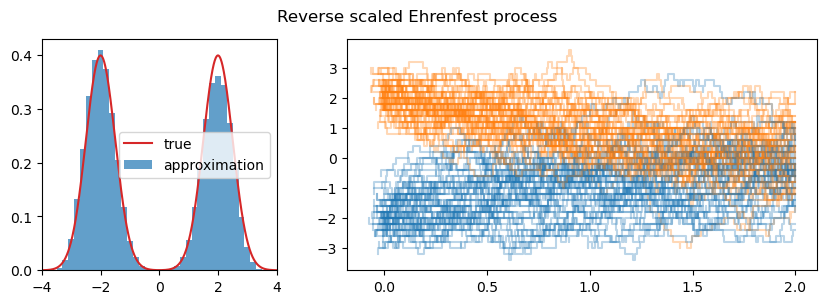

In [694]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'width_ratios': [1, 2]})

fig.suptitle("Reverse scaled Ehrenfest process")

E_T_counts = np.bincount(np.round(((np.array(E_T) / 2 *
                          np.sqrt(S) + S / 2) )).astype("int"), minlength=S)
p_approx = E_T_counts / np.sum(E_T_counts)

ax[0].plot(x_val, 0.5 * norm.pdf(x_val, loc=-2, scale=0.5) +
         0.5 * norm.pdf(x_val, loc=2, scale=0.5), color="tab:red", label="true")
ax[0].bar(x=(np.linspace(0, S-1, S) - S / 2) * 2 / np.sqrt(S), width=2 / np.sqrt(S), height=p_approx / 2 * np.sqrt(S), alpha=0.7, label="approximation");
ax[0].legend();
ax[0].set_xlim(-4, 4)

for i in range(log_trajectories):
    ax[1].plot(np.repeat(time_logs[i], 2)[1:], np.repeat(E_logs[i], 2)[:-1], alpha=0.3,
             color=COLORS[int(E_logs[i][-1] > 0)])

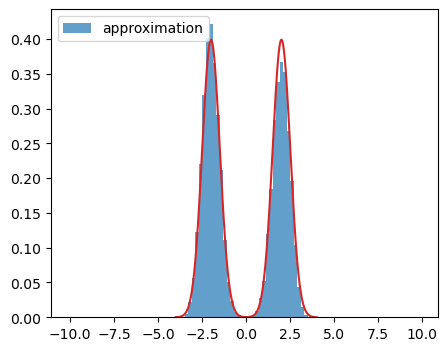

## Plot for paper

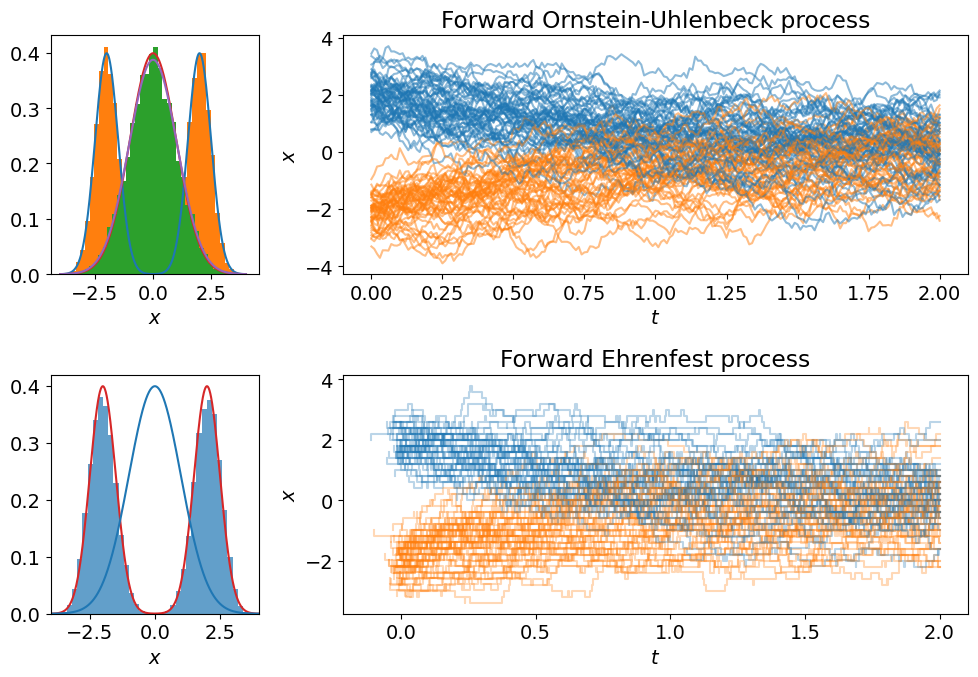

In [730]:
font = {'size'   : 14}

plt.rc('font', **font)

fig, ax = plt.subplots(2, 2, figsize=(10, 7), gridspec_kw={'width_ratios': [1, 3]})

ax[0, 0].plot(x_val, np.sum([alpha[m] * norm.pdf(x_val, loc=mu[m], scale=sigma[m]) 
                          for m in range(M)], 0));
ax[0, 0].hist(X_data, bins=40, density=True);
ax[0, 0].hist(X, bins=40, density=True);
ax[0, 0].plot(x_val, norm.pdf(x_val, loc=0, scale=1))
ax[0, 0].plot(x_val, density(x_val, T))
ax[0, 0].set_xlabel(r"$x$")

ax[0, 1].set_title("Forward Ornstein-Uhlenbeck process")
for k in range(K_traj):
    ax[0, 1].plot(t_val, X_traj[:, k], color=COLORS[int(X_traj[0, k] < 0)], alpha=0.5)
ax[0, 1].set_xlabel(r"$t$")
ax[0, 1].set_ylabel(r"$x$")
    
    
E_T_counts = np.bincount(np.round(((np.array(E_T) / 2 *
                          np.sqrt(S) + S / 2) )).astype("int"), minlength=S)
p_approx = E_T_counts / np.sum(E_T_counts)

ax[1, 0].plot(x_val, 0.5 * norm.pdf(x_val, loc=-2, scale=0.5) +
         0.5 * norm.pdf(x_val, loc=2, scale=0.5), color="tab:red", label="true")
ax[1, 0].bar(x=(np.linspace(0, S-1, S) - S / 2) * 2 / np.sqrt(S), width=2 / np.sqrt(S), height=p_approx / 2 * np.sqrt(S), alpha=0.7, label="approximation");
#ax[1, 0].legend();
ax[1, 0].plot(x_val, norm.pdf(x_val, loc=0, scale=1))
ax[1, 0].set_xlim(-4, 4)
ax[1, 0].set_xlabel(r"$x$")

ax[1, 1].set_title("Forward Ehrenfest process")
for i in range(log_trajectories):
    ax[1, 1].plot(np.repeat(time_logs[i], 2)[1:], np.repeat(E_logs[i], 2)[:-1], alpha=0.3,
             color=COLORS[int(E_logs[i][-1] < 0)])
ax[1, 1].set_xlabel(r"$t$")
ax[1, 1].set_ylabel(r"$x$")
    
fig.tight_layout()

fig.savefig("img/forward_OU_Ehrenfest.pdf")